<a href="https://colab.research.google.com/github/anaisaoviedo-upb/Hiperparametrizacion/blob/main/Hiperparametrizacion_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hiperparametrizacion para Clasificación: Predicción de la Calidad del Aire

1. Preparación de Datos
2. División de los Datos
3. Hiperparametrización con el 70%
4. Evaluación del mejor Modelo con el 30%
5. Guardar el Modelo

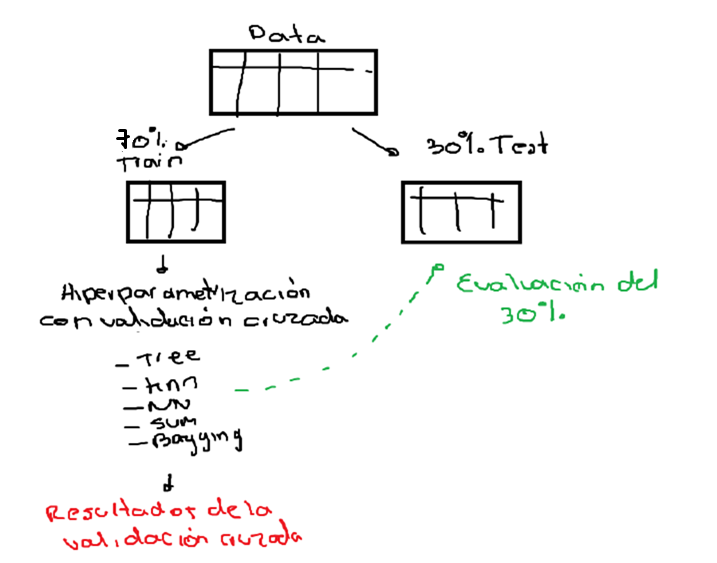

In [ ]:
#Cargamos librerías principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Preparación de Datos


In [ ]:
#Cargamos los datos
data = pd.read_excel("prediccionCalidadAire.xlsx", sheet_name='Historico')
data.head()

,Clima,Temperatura,Humedad,PM25,Alerta
0,lluvioso,65,70,245,Si
1,lluvioso,71,91,253,Si
2,lluvioso,65,70,298,Si
3,lluvioso,71,91,278,Si
4,nublado,65,70,243,Si


In [ ]:
#Conocemos los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Clima        220 non-null    object
 1   Temperatura  220 non-null    int64 
 2   Humedad      220 non-null    int64 
 3   PM25         220 non-null    int64 
 4   Alerta       220 non-null    object
dtypes: int64(3), object(2)
memory usage: 8.7+ KB


In [ ]:
#Corrección de tipo de datos


In [ ]:
#Descripción de variables numéricas
data.describe()

,Temperatura,Humedad,PM25
count,220.000000,220.000000,220.000000
mean,70.550000,81.100000,175.754545
std,5.984169,10.386547,102.123409
min,64.000000,65.000000,10.000000
25%,65.000000,70.000000,50.000000
50%,70.500000,82.500000,200.000000
75%,71.250000,91.000000,255.750000
max,85.000000,96.000000,298.000000


<Axes: ylabel='count'>

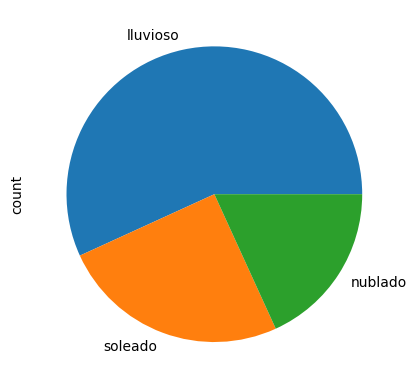

In [ ]:
#Descripción variables categóricas
data['Clima'].value_counts().plot(kind='pie')

<Axes: xlabel='Alerta'>

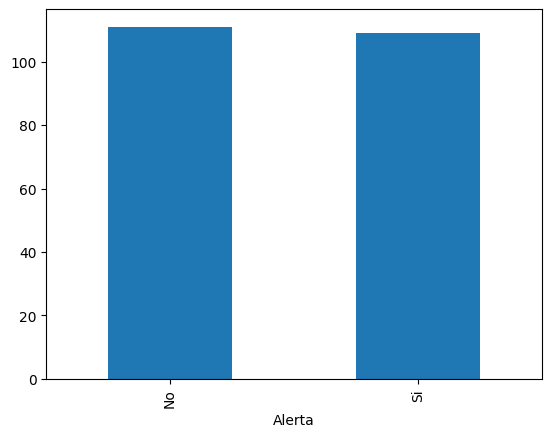

In [ ]:
data['Alerta'].value_counts().plot(kind='bar')

<Axes: ylabel='Frequency'>

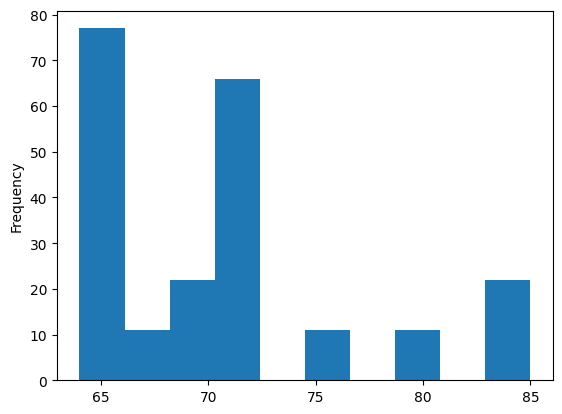

In [ ]:
data['Temperatura'].plot(kind='hist')

In [ ]:
#Sklearn sólo analiza variables numéricas
data = pd.get_dummies(data, columns=['Clima'], drop_first=False, dtype=int)
data.head()

,Temperatura,Humedad,PM25,Alerta,Clima_lluvioso,Clima_nublado,Clima_soleado
0,65,70,245,Si,1,0,0
1,71,91,253,Si,1,0,0
2,65,70,298,Si,1,0,0
3,71,91,278,Si,1,0,0
4,65,70,243,Si,0,1,0


In [ ]:
#Se codifican las categorias de la VARIABLE OBJETIVO

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
data["Alerta"]=labelencoder.fit_transform(data["Alerta"])

data.head()

,Temperatura,Humedad,PM25,Alerta,Clima_lluvioso,Clima_nublado,Clima_soleado
0,65,70,245,1,1,0,0
1,71,91,253,1,1,0,0
2,65,70,298,1,1,0,0
3,71,91,278,1,1,0,0
4,65,70,243,1,0,1,0


# 2. División 70-30


<Axes: xlabel='Alerta'>

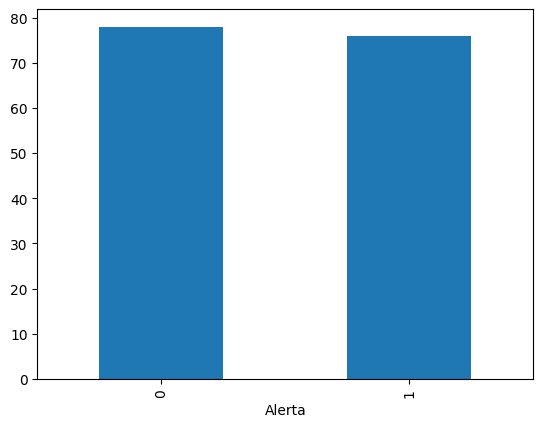

In [ ]:
#División 70-30
from sklearn.model_selection import train_test_split
X = data.drop("Alerta", axis = 1) # Variables predictoras
Y = data['Alerta'] #Variable objetivo
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y) #Muestreo estratificado
Y_train.value_counts().plot(kind='bar')

In [ ]:
#Balanceo 70% Train

# 3. Hiperparametrización con el 70%

In [ ]:
#Medida de evaluación del mejor modelo
medidas= pd.DataFrame(index=['f1 de la CV'])

# **Hiperparametrización Arbol de Clasificación**

In [ ]:
#  Arbol
from sklearn.tree import DecisionTreeClassifier
modelTree = DecisionTreeClassifier()

# Definir los hiperparametros
criterion=['entropy','gini'] #Indice de información
min_samples_leaf=[2,10,50,100] # Cantidad de registros por hoja
max_depth=[None, 10,20,50] #Niveles de profundidad



In [ ]:
#Hiperparametrización
from sklearn.model_selection import GridSearchCV

param_grid = dict(criterion=criterion, min_samples_leaf=min_samples_leaf, max_depth=max_depth)
grid = GridSearchCV(estimator=modelTree, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=3) #cv=10
grid.fit(X_train, Y_train) #70%

#Mejor modelo
modelTree= grid.best_estimator_


medidas['Tree']=grid.best_score_

# Mejores párametros
print( grid.best_params_)
print(medidas)

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2}
                 Tree
f1 de la CV  0.967434


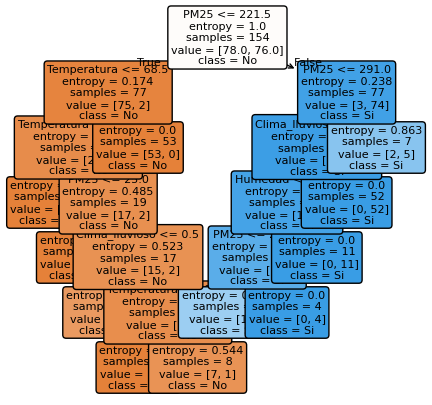

In [ ]:
#Mejor modelo
from sklearn.tree import plot_tree
plt.figure(figsize=(5,5))
plot_tree(modelTree, feature_names=X_train.columns.values, class_names=labelencoder.classes_, rounded=True, filled=True, fontsize=8)
plt.show()

# **Hiperparametrización Knn para Clasificación**

In [ ]:
#Normalizacion las variables numéricas (las dummies no se normalizan)
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
variables_numericas=['Temperatura',	'Humedad',	'PM25']
min_max_scaler.fit(data[variables_numericas]) #Ajuste de los parametros: max - min

#Se aplica la normalización a 70%  y la del 30% se hace mas adelante
X_train[variables_numericas]= min_max_scaler.transform(X_train[variables_numericas]) #70%

#La normalización de X_test se aplica mas adelante
X_train.head()

,Temperatura,Humedad,PM25,Clima_lluvioso,Clima_nublado,Clima_soleado
91,0.761905,0.806452,0.461806,0,0,1
149,0.333333,0.838710,0.881944,1,0,0
140,0.047619,0.161290,0.815972,1,0,0
34,0.190476,0.483871,0.069444,1,0,0
92,0.904762,0.677419,0.815972,0,1,0


In [ ]:
#KNN
from sklearn.neighbors  import KNeighborsClassifier
modelKnn = KNeighborsClassifier()

# Definir los hiperparametros
n_neighbors=[1,3,5,7,13,27]
metric=['euclidean','minkowski']

#Grid
param_grid = dict(n_neighbors=n_neighbors, metric=metric)
grid = GridSearchCV(estimator=modelKnn, param_grid=param_grid, scoring='f1_macro', n_jobs=-1,cv=10)
grid.fit(X_train, Y_train) #70%

#Mejor modelo
modelKnn= grid.best_estimator_

#Medida de evaluación del mejor modelo
medidas['Knn']=grid.best_score_

# Mejores párametros
print( grid.best_params_)
print(medidas)

{'metric': 'euclidean', 'n_neighbors': 3}
                 Tree       Knn
f1 de la CV  0.967434  0.948545


# **Hiperparametrización Red Neuronal**

In [ ]:
#Red Neuronal

from sklearn.neural_network import MLPClassifier
modelNN = MLPClassifier()


# Definir los parametros
random_state=[1] #Semilla para generar número pseudoaleatorios
solver=['sgd'] # Regla de aprendizaje ['adam','sgd','lbfgs']
learning_rate=['constant','adaptive'] #tasa de aprendizaje
learning_rate_init=[0.2, 0.5, 1.5] #valor tasa de aprendizaje
momentum=[0.3, 0.5, 1.0] #momentum
activation=['logistic', 'relu'] #'identity’, ‘logistic’, ‘tanh’, ‘relu’
hidden_layer_sizes=[20,100,[8, 20]] # neuronas de la capa oculta (input+output/2)
max_iter = [100,500] #iteraciones

#Grid
param_grid = dict(random_state=random_state,solver=solver,activation=activation, hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, learning_rate=learning_rate,
                  learning_rate_init=learning_rate_init, momentum=momentum)
grid = GridSearchCV(estimator=modelNN, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=3)
grid.fit(X_train, Y_train)

#Mejor modelo
modelNN= grid.best_estimator_

#Medida de evaluación del mejor modelo
medidas['NN']=grid.best_score_

# Mejores párametros
print( grid.best_params_)
print(medidas)

{'activation': 'logistic', 'hidden_layer_sizes': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.2, 'max_iter': 100, 'momentum': 1.0, 'random_state': 1, 'solver': 'sgd'}
                 Tree       Knn        NN
f1 de la CV  0.967434  0.948545  0.967434


# **Hiperparametrización SVM para Clasificación**

In [ ]:
#SVM
from sklearn.svm import SVC
modelSVM = SVC()

# Definir los hiperparametros
C=[0.1,1,10] #Margen blando 1
kernel=['linear', 'rbf','poly'] #'linear', 'poly', 'rbf', 'sigmoid'
gamma=['scale','auto',0.01,5,3]

#Grid
param_grid = dict(C=C, kernel=kernel,gamma=gamma)
grid = GridSearchCV(estimator=modelSVM, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=3)
grid.fit(X_train, Y_train)

#Mejor modelo
modelSVM= grid.best_estimator_

#Medida de evaluación del mejor modelo
medidas['SVM']=grid.best_score_

# Mejores párametros
print( grid.best_params_)

print(medidas)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
                 Tree       Knn        NN       SVM
f1 de la CV  0.967434  0.948545  0.967434  0.967434


# **Hiperparametrización Ensambles - Bagging**

In [ ]:
#Bagging
from sklearn.ensemble import BaggingClassifier
model_bag = BaggingClassifier()


# Definir los hiperparametros
base_knn= KNeighborsClassifier(n_neighbors=1, metric='euclidean')

base_nn1= MLPClassifier(activation="logistic",hidden_layer_sizes=(10), learning_rate='adaptive',
                     learning_rate_init=0.2, momentum= 0.3, max_iter=500, verbose=False)

base_nn2= MLPClassifier(activation="relu",hidden_layer_sizes=(4), learning_rate='adaptive',
                     learning_rate_init=0.2, momentum= 0.3, max_iter=100, verbose=False)


base_estimator=[base_knn, base_nn1, base_nn2] #Métodos de Machine Learning
n_estimators=[10,50,100]
max_samples=[0.6,0.7,0.8]

#Grid
param_grid = dict(estimator=base_estimator, n_estimators=n_estimators,max_samples=max_samples)
grid = GridSearchCV(estimator=model_bag, param_grid=param_grid, scoring='f1_macro', n_jobs=-1, cv=3)
grid.fit(X_train, Y_train)

#Mejor modelo
model_bag= grid.best_estimator_

#Medida de evaluación del mejor modelo
medidas['Bagging']=grid.best_score_

# Mejores párametros
print( grid.best_params_)

print(medidas)

{'estimator': KNeighborsClassifier(metric='euclidean', n_neighbors=1), 'max_samples': 0.6, 'n_estimators': 100}
                 Tree       Knn        NN       SVM   Bagging
f1 de la CV  0.967434  0.948545  0.967434  0.967434  0.967434


# **4. Evaluación de los mejores modelos con el 30%**

              precision    recall  f1-score   support

          No       0.94      0.97      0.96        33
          Si       0.97      0.94      0.95        33

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.95      0.95      0.95        66



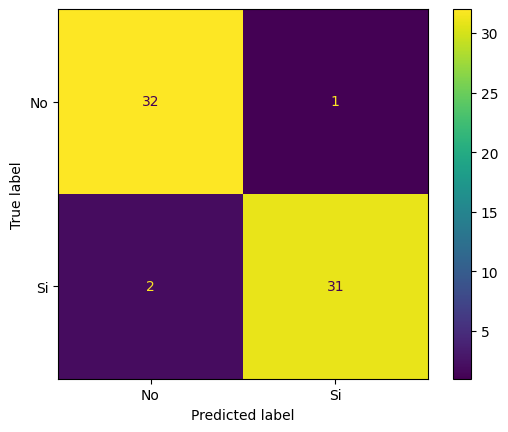

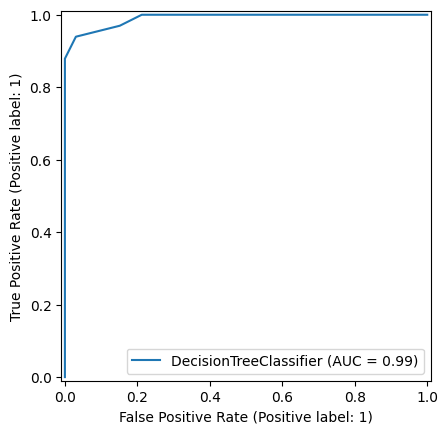

In [ ]:
#Evaluación del mejor Tree con el 30% (X_test sin normalizar)
from sklearn import metrics

Y_pred = modelTree.predict(X_test) #30%

#Matriz de confusion
cm=metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labelencoder.classes_)
disp.plot()

#Precision, Recall, f1, exactitud
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

# Curva ROC
metrics.RocCurveDisplay.from_estimator(modelTree,X_test, Y_test)

In [ ]:
#X_test se normaliza para lo otros métodos
X_test[variables_numericas]= min_max_scaler.transform(X_test[variables_numericas])  #30%
X_test

,Temperatura,Humedad,PM25,Clima_lluvioso,Clima_nublado,Clima_soleado
186,0.047619,0.161290,0.121528,1,0,0
36,0.000000,0.000000,0.138889,0,1,0
78,0.238095,0.161290,0.000000,0,0,1
103,0.333333,0.838710,0.930556,1,0,0
130,1.000000,0.645161,0.652778,0,0,1
...,...,...,...,...,...,...
39,0.523810,0.483871,0.048611,1,0,0
152,0.904762,0.677419,0.267361,0,1,0
3,0.333333,0.838710,0.930556,1,0,0
194,0.190476,0.483871,0.069444,1,0,0


              precision    recall  f1-score   support

          No       0.84      0.97      0.90        33
          Si       0.96      0.82      0.89        33

    accuracy                           0.89        66
   macro avg       0.90      0.89      0.89        66
weighted avg       0.90      0.89      0.89        66



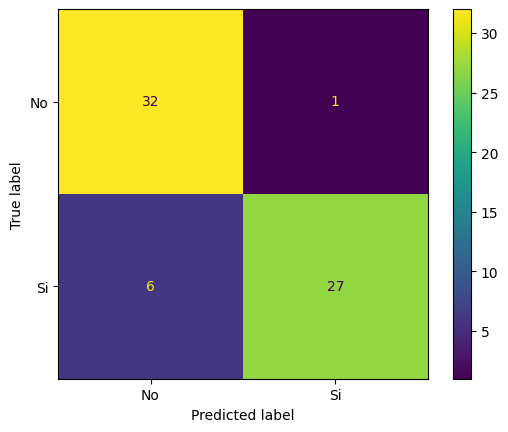

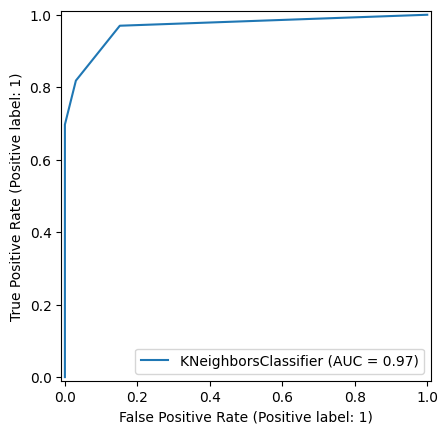

In [ ]:
#Evaluación de Knn
from sklearn import metrics

Y_pred = modelKnn.predict(X_test)

#Matriz de confusion
cm=metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labelencoder.classes_)
disp.plot()

#Precision, Recall, f1, exactitud
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

# Curva ROC
metrics.RocCurveDisplay.from_estimator(modelKnn,X_test, Y_test)

              precision    recall  f1-score   support

          No       0.94      0.97      0.96        33
          Si       0.97      0.94      0.95        33

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.95      0.95      0.95        66



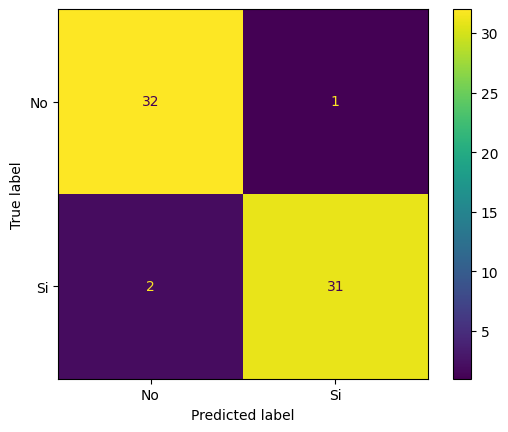

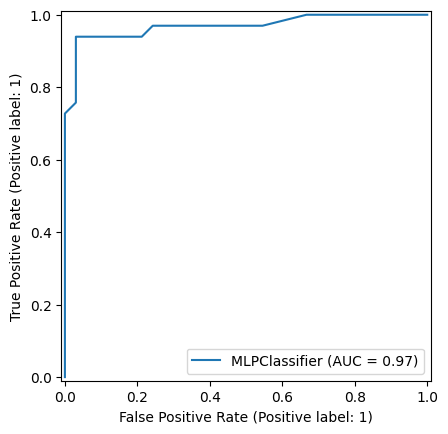

In [ ]:
#Evaluación de Red Neuronal
from sklearn import metrics

Y_pred = modelNN.predict(X_test)

#Matriz de confusion
cm=metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labelencoder.classes_)
disp.plot()

#Precision, Recall, f1, exactitud
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

# Curva ROC
metrics.RocCurveDisplay.from_estimator(modelNN,X_test, Y_test)

              precision    recall  f1-score   support

          No       0.94      0.97      0.96        33
          Si       0.97      0.94      0.95        33

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.95      0.95      0.95        66



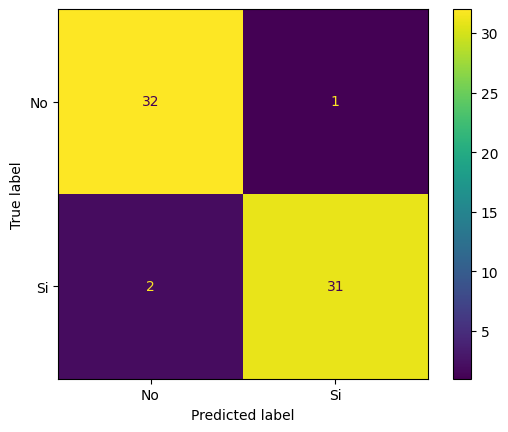

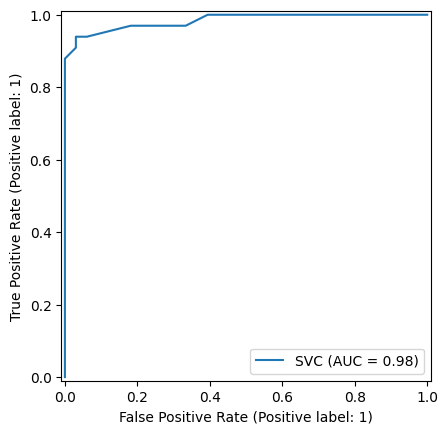

In [ ]:
#Evaluación de SVM
from sklearn import metrics

Y_pred = modelSVM.predict(X_test)

#Matriz de confusion
cm=metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labelencoder.classes_)
disp.plot()

#Precision, Recall, f1, exactitud
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

# Curva ROC
metrics.RocCurveDisplay.from_estimator(modelSVM,X_test, Y_test)

              precision    recall  f1-score   support

          No       0.94      0.97      0.96        33
          Si       0.97      0.94      0.95        33

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.95      0.95      0.95        66



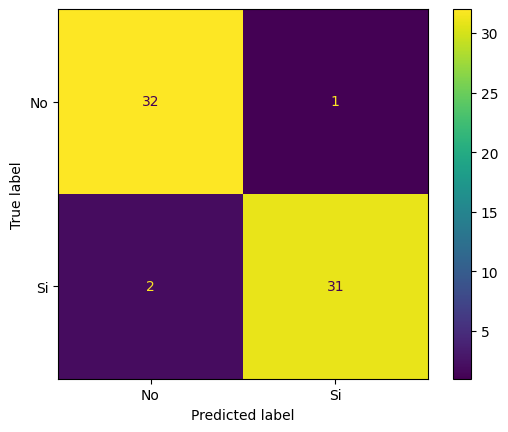

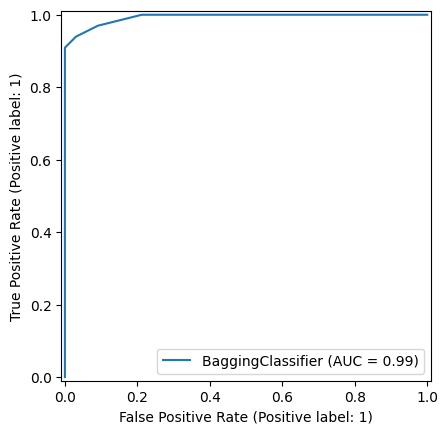

In [ ]:
#Evaluación de Bagging
from sklearn import metrics

Y_pred = model_bag.predict(X_test)

#Matriz de confusion
cm=metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred)
disp=metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labelencoder.classes_)
disp.plot()

#Precision, Recall, f1, exactitud
print(metrics.classification_report( y_true=Y_test, y_pred=Y_pred, target_names=labelencoder.classes_))

# Curva ROC
metrics.RocCurveDisplay.from_estimator(model_bag,X_test, Y_test)

# 4. Guardamos el modelo

* En la validación cruzada cuál tiene mejor calidad?
* En la evaluación del 30% cuál tiene mejor calidad?

In [ ]:
import pickle
filename = 'modelo-clas-hiper.pkl'
variables= X.columns._values
pickle.dump([modelTree,labelencoder,variables,min_max_scaler], open(filename, 'wb')) #write
